In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /root/.kaggle

In [ ]:
# !cp /content/drive/MyDrive/kaggle.json /root/.kaggle/
!cp '/content/kaggle.json' /root/.kaggle/

In [ ]:
!kaggle datasets download -d ahtcmstp/jaffe2021

  0% 0.00/3.78M [00:00<?, ?B/s]
100% 3.78M/3.78M [00:00<00:00, 229MB/s]


In [ ]:
!kaggle datasets download -d msambare/fer2013

100% 60.3M/60.3M [00:03<00:00, 22.4MB/s]
100% 60.3M/60.3M [00:03<00:00, 16.7MB/s]


In [ ]:
!unzip jaffe2021.zip

Archive:  jaffe2021.zip
  inflating: Jaffe-20211229/Data_Images/Training/Anger/Images0.jpeg  
  inflating: Jaffe-20211229/Data_Images/Training/Anger/Images1.jpeg  
  inflating: Jaffe-20211229/Data_Images/Training/Anger/Images10.jpeg  
  inflating: Jaffe-20211229/Data_Images/Training/Anger/Images11.jpeg  
  inflating: Jaffe-20211229/Data_Images/Training/Anger/Images12.jpeg  
  inflating: Jaffe-20211229/Data_Images/Training/Anger/Images13.jpeg  
  inflating: Jaffe-20211229/Data_Images/Training/Anger/Images14.jpeg  
  inflating: Jaffe-20211229/Data_Images/Training/Anger/Images15.jpeg  
  inflating: Jaffe-20211229/Data_Images/Training/Anger/Images16.jpeg  
  inflating: Jaffe-20211229/Data_Images/Training/Anger/Images17.jpeg  
  inflating: Jaffe-20211229/Data_Images/Training/Anger/Images18.jpeg  
  inflating: Jaffe-20211229/Data_Images/Training/Anger/Images19.jpeg  
  inflating: Jaffe-20211229/Data_Images/Training/Anger/Images2.jpeg  
  inflating: Jaffe-20211229/Data_Images/Training/Anger/I

In [ ]:
!unzip fer2013.zip

In [ ]:
jaffee_dataset = '/content/Jaffe-20211229/Data_Images/Training'

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from google.colab import drive

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Set GPU device
print(torch.cuda.is_available())
device = torch.device("cuda:0")

True


In [ ]:
# Auxiliary function for data distribution visualization
import cv2
def data_visualization(classes, data):
    # Define the color scheme for the bar graph
    colors = ['orange','red', 'blue', 'green', 'yellow', 'purple',  'violet']
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.bar(classes, data, color=colors)
    ax.set(title="Dataset's distribution for each Emotion class")
    ax.set(xlabel="Emotions", ylabel="#Images");
    ax.grid()


def load_data(data_path):
    subfolders_ck = os.listdir(data_path)

    print("[INFO] Dataset Loading...\n")

    img_data_list=[]
    labels_list = []
    num_images_per_class = []

    for category in subfolders_ck:
        img_list=os.listdir(data_path +'/'+ category)

        print('Loading :', len(img_list), 'images of category', category)
        for img in img_list:
            # Load an image from this path
            pixels=cv2.imread(data_path + '/'+ category + '/'+ img )
            face_array=cv2.resize(pixels, None, fx=1, fy=1,interpolation = cv2.INTER_CUBIC)

            img_data_list.append(face_array)
            labels_list.append(category)

        num_images_per_class.append(len(img_list))

    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    # labels = to_categorical(labels, 7)
    data = np.array(img_data_list)

    data_visualization(subfolders_ck, num_images_per_class)

    # Dataset Summary
    print("\nTotal number of uploaded data:", data.shape[0],
          ", with data shape", (data.shape[1],data.shape[2],data.shape[3]))

    return data, labels

[INFO] Dataset Loading...

Loading : 20 images of category Surprise
Loading : 20 images of category Disgust
Loading : 22 images of category Neutral
Loading : 21 images of category Sadness
Loading : 22 images of category Anger
Loading : 22 images of category Fear
Loading : 23 images of category Happiness

Total number of uploaded data: 150 , with data shape (224, 224, 3)


(150,)

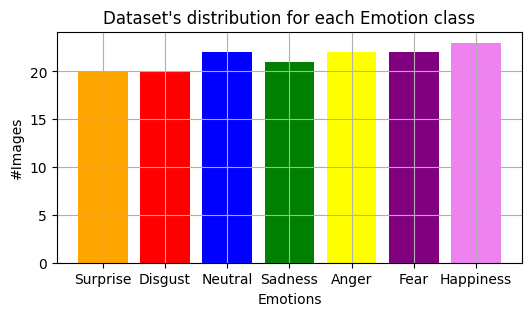

In [ ]:
data_path_ck = jaffee_dataset
data, labels = load_data(data_path_ck)
l = labels
l.shape

In [ ]:
from sklearn.model_selection import train_test_split

# assuming your dataset is stored in X and y arrays

# first split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# then split the training data further into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.utils import to_categorical

# Assume that the y_train array is already defined as a 1D array of integers

# Convert y_train to categorical
num_classes = 7 # for example, if y_train contains 10 classes
y_train = to_categorical(y_train, num_classes)
# y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
X_train.shape, y_train.shape,  X_test.shape, y_test.shape

((120, 224, 224, 3), (120, 7), (30, 224, 224, 3), (30, 7))

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        if self.transform:
            x = self.transform(x)
        return x, y

train_dataset = CustomDataset(X_train, y_train, transform=transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor()
                        ]))

test_dataset = CustomDataset(X_test, y_test, transform=transforms.Compose([
                            transforms.Resize((224, 224)),
                            transforms.ToTensor()
                        ]))


In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
import os
import shutil
import random

data_dir = jaffee_dataset  # Replace with the actual path to your CKPlus dataset
train_dir = '/content/jtrain_dir'  # Replace with the path where you want to store the training set
test_dir = '/content/jtest_dir'  # Replace with the path where you want to store the testing set
test_ratio = 0.2  # The ratio of data to be used for testing

# Create the train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate over the subfolders and randomly assign them to the train or test set
for emo_folder in os.listdir(data_dir):
    emo_path = os.path.join(data_dir, emo_folder)
    if not os.path.isdir(emo_path):
        continue
    images = os.listdir(emo_path)
    num_test = int(len(images) * test_ratio)
    test_images = random.sample(images, num_test)
    for img in images:
        src = os.path.join(emo_path, img)
        if img in test_images:
            dst = os.path.join(test_dir, emo_folder, img)
        else:
            dst = os.path.join(train_dir, emo_folder, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)


In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)

        # Replace output layer according to our problem
        in_feats = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(in_feats, 7)

    def forward(self, x):
        x = self.vgg16(x)
        return x

model = CNNModel()
model.to(device)
model

CNNModel(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [ ]:
# %% Prepare data for pretrained model
train_dataset = torchvision.datasets.ImageFolder(
        root='/content/jtrain_dir',
        transform=transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor()
        ])
)

test_dataset = torchvision.datasets.ImageFolder(
        root='/content/jtest_dir',
        transform=transforms.Compose([
                      transforms.Resize((224,224)),
                      transforms.ToTensor()
        ])
)

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
# %% Train
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00002)
epochs = 100

In [ ]:
# Iterate x epochs over the train data
for epoch in range(1,epochs):
    for i, batch in enumerate(train_loader, 0):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # Labels are automatically one-hot-encoded
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        print("Epochs:",epoch,"of", epochs,loss)


Epochs: 1 of 100 tensor(2.0345, device='cuda:0', grad_fn=<NllLossBackward0>)
Epochs: 1 of 100 tensor(1.9715, device='cuda:0', grad_fn=<NllLossBackward0>)
Epochs: 2 of 100 tensor(1.9482, device='cuda:0', grad_fn=<NllLossBackward0>)
Epochs: 2 of 100 tensor(2.0869, device='cuda:0', grad_fn=<NllLossBackward0>)
Epochs: 3 of 100 tensor(2.0655, device='cuda:0', grad_fn=<NllLossBackward0>)
Epochs: 3 of 100 tensor(2.0499, device='cuda:0', grad_fn=<NllLossBackward0>)
Epochs: 4 of 100 tensor(2.0279, device='cuda:0', grad_fn=<NllLossBackward0>)
Epochs: 4 of 100 tensor(1.9748, device='cuda:0', grad_fn=<NllLossBackward0>)
Epochs: 5 of 100 tensor(2.0018, device='cuda:0', grad_fn=<NllLossBackward0>)
Epochs: 5 of 100 tensor(1.9749, device='cuda:0', grad_fn=<NllLossBackward0>)
Epochs: 6 of 100 tensor(2.1052, device='cuda:0', grad_fn=<NllLossBackward0>)
Epochs: 6 of 100 tensor(1.9469, device='cuda:0', grad_fn=<NllLossBackward0>)
Epochs: 7 of 100 tensor(2.0559, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
# Iterate x epochs over the train data
print_freq = 5  # Print loss and accuracy every 100 iterations

for epoch in range(1, epochs+1):
    total_loss = 0.0
    correct = 0
    total = 0

    for i, batch in enumerate(train_loader, 0):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Calculate loss
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update statistics
        total_loss += loss.item()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print loss and accuracy every x iterations
        # if (i+1) % print_freq == 0:
        avg_loss = total_loss / print_freq
        accuracy = 100.0 * correct / total
        print(f'Epoch [{epoch}/{epochs}], Iteration [{i+1}/{len(train_loader)}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
        total_loss = 0.0
        correct = 0
        total = 0

Epoch [1/100], Iteration [1/2], Loss: 0.4124, Accuracy: 21.88%
Epoch [1/100], Iteration [2/2], Loss: 0.3904, Accuracy: 18.97%
Epoch [2/100], Iteration [1/2], Loss: 0.4212, Accuracy: 18.75%
Epoch [2/100], Iteration [2/2], Loss: 0.4166, Accuracy: 12.07%
Epoch [3/100], Iteration [1/2], Loss: 0.3879, Accuracy: 10.94%
Epoch [3/100], Iteration [2/2], Loss: 0.4177, Accuracy: 15.52%
Epoch [4/100], Iteration [1/2], Loss: 0.4146, Accuracy: 21.88%
Epoch [4/100], Iteration [2/2], Loss: 0.4215, Accuracy: 12.07%
Epoch [5/100], Iteration [1/2], Loss: 0.3974, Accuracy: 20.31%
Epoch [5/100], Iteration [2/2], Loss: 0.3991, Accuracy: 15.52%
Epoch [6/100], Iteration [1/2], Loss: 0.3924, Accuracy: 15.62%
Epoch [6/100], Iteration [2/2], Loss: 0.4025, Accuracy: 12.07%
Epoch [7/100], Iteration [1/2], Loss: 0.3939, Accuracy: 18.75%
Epoch [7/100], Iteration [2/2], Loss: 0.4272, Accuracy: 13.79%
Epoch [8/100], Iteration [1/2], Loss: 0.4118, Accuracy: 20.31%
Epoch [8/100], Iteration [2/2], Loss: 0.4159, Accuracy:

In [ ]:
import torch

# Load the saved model
# model = CNNModel()  # Replace YourModelClass with the actual class of your model
# model.load_state_dict(torch.load("/content/drive/MyDrive/CK+_RAF_model_50Epo.pth"))
model.eval()  # Set the model to evaluation mode

# Rest of your testing code
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = cross_entropy_loss(outputs, labels)
        test_loss += loss.item()

    test_loss /= len(test_loader)
    accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")


Test Loss: 1.0412
Test Accuracy: 82.14%


In [ ]:
import matplotlib.pyplot as plt

def generate_heatmap(pixel_relevance_scores):
    # Normalize the relevance scores between 0 and 1
    normalized_scores = (pixel_relevance_scores - np.min(pixel_relevance_scores)) / (np.max(pixel_relevance_scores) - np.min(pixel_relevance_scores))

    # Create the heatmap using the normalized relevance scores
    heatmap = plt.imshow(normalized_scores, cmap='jet')

    # Add a colorbar to the heatmap
    plt.colorbar(heatmap)

    # Show the generated heatmap
    plt.show()


In [ ]:
# Testing the model accuracy
model.eval()  # Set the model to evaluation mode

test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = cross_entropy_loss(outputs, labels)
        test_loss += loss.item()

    test_loss /= len(test_loader)
    accuracy = 100 * correct / total

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.2f}%")


Test Loss: 1.0412
Test Accuracy: 82.14%


In [ ]:

# %% Inspect predictions for first batch test/train loader
import pandas as pd

inputs, labels = next(iter(test_loader))
# inputs, labels = next(iter(train_loader))
inputs = inputs.to(device)
labels = labels.numpy()
outputs = model(inputs).max(1).indices.detach().cpu().numpy()

comparison = pd.DataFrame()
print("Batch predictions:")
print(outputs)

comparison["actual"] = labels
comparison["predicted"] = outputs

print("\nComparison:")
print(comparison)

Batch predictions:
[0 3 4 6 0 3 2 4 3 0 6 4 4 1 5 5 5 0 5 3 2 6 6 1 5 1 2 3]

Comparison:
    actual  predicted
0        0          0
1        3          3
2        4          4
3        6          6
4        0          0
5        3          3
6        2          2
7        4          4
8        3          3
9        0          0
10       6          6
11       5          4
12       4          4
13       1          1
14       5          5
15       4          5
16       5          5
17       0          0
18       2          5
19       5          3
20       2          2
21       6          6
22       6          6
23       1          1
24       1          5
25       1          1
26       2          2
27       3          3


In [ ]:
def new_layer(layer, g):
    """Clone a layer and pass its parameters through the function g."""
    layer = copy.deepcopy(layer)
    try: layer.weight = torch.nn.Parameter(g(layer.weight))
    except AttributeError: pass
    try: layer.bias = torch.nn.Parameter(g(layer.bias))
    except AttributeError: pass
    return layer

In [ ]:
def dense_to_conv(layers):
    """ Converts a dense layer to a conv layer """
    newlayers = []
    for i,layer in enumerate(layers):
        if isinstance(layer, nn.Linear):
            newlayer = None
            if i == 0:
                m, n = 512, layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,7)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,7,7))
            else:
                m,n = layer.weight.shape[1],layer.weight.shape[0]
                newlayer = nn.Conv2d(m,n,1)
                newlayer.weight = nn.Parameter(layer.weight.reshape(n,m,1,1))
            newlayer.bias = nn.Parameter(layer.bias)
            newlayers += [newlayer]
        else:
            newlayers += [layer]
    return newlayers

In [ ]:
def get_linear_layer_indices(model):
    offset = len(model.vgg16._modules['features']) + 1
    indices = []
    for i, layer in enumerate(model.vgg16._modules['classifier']):
        if isinstance(layer, nn.Linear):
            indices.append(i)
    indices = [offset + val for val in indices]
    return indices

In [ ]:
def apply_lrp_on_vgg16(model, image):
    image = torch.unsqueeze(image, 0)
    # >>> Step 1: Extract layers
    layers = list(model.vgg16._modules['features']) \
                + [model.vgg16._modules['avgpool']] \
                + dense_to_conv(list(model.vgg16._modules['classifier']))
    linear_layer_indices = get_linear_layer_indices(model)
    # >>> Step 2: Propagate image through layers and store activations
    n_layers = len(layers)
    activations = [image] + [None] * n_layers # list of activations

    for layer in range(n_layers):
        if layer in linear_layer_indices:
            if layer == 32:
                activations[layer] = activations[layer].reshape((1, 512, 7, 7))
        activation = layers[layer].forward(activations[layer])
        if isinstance(layers[layer], torch.nn.modules.pooling.AdaptiveAvgPool2d):
            activation = torch.flatten(activation, start_dim=1)
        activations[layer+1] = activation

    # >>> Step 3: Replace last layer with one-hot-encoding
    output_activation = activations[-1].detach().cpu().numpy()
    max_activation = output_activation.max()
    one_hot_output = [val if val == max_activation else 0
                        for val in output_activation[0]]

    activations[-1] = torch.FloatTensor([one_hot_output]).to(device)

    # >>> Step 4: Backpropagate relevance scores
    relevances = [None] * n_layers + [activations[-1]]
    # Iterate over the layers in reverse order
    for layer in range(0, n_layers)[::-1]:
        current = layers[layer]
        # Treat max pooling layers as avg pooling
        if isinstance(current, torch.nn.MaxPool2d):
            layers[layer] = torch.nn.AvgPool2d(2)
            current = layers[layer]
        if isinstance(current, torch.nn.Conv2d) or \
           isinstance(current, torch.nn.AvgPool2d) or\
           isinstance(current, torch.nn.Linear):
            activations[layer] = activations[layer].data.requires_grad_(True)

            # Apply variants of LRP depending on the depth
            # see: https://link.springer.com/chapter/10.1007%2F978-3-030-28954-6_10
            # Lower layers, LRP-gamma >> Favor positive contributions (activations)
            if layer <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
            # Middle layers, LRP-epsilon >> Remove some noise / Only most salient factors survive
            if 17 <= layer <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
            # Upper Layers, LRP-0 >> Basic rule
            if layer >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

            # Transform weights of layer and execute forward pass
            z = incr(new_layer(layers[layer],rho).forward(activations[layer]))
            # Element-wise division between relevance of the next layer and z
            s = (relevances[layer+1]/z).data
            # Calculate the gradient and multiply it by the activation
            (z * s).sum().backward();
            c = activations[layer].grad
            # Assign new relevance values
            relevances[layer] = (activations[layer]*c).data
        else:
            relevances[layer] = relevances[layer+1]

    # >>> Potential Step 5: Apply different propagation rule for pixels
    return relevances[0]

In [ ]:
def get_pixel_count_in_range(array):
  array = array.flatten()
  count_range = []
  for i in range(10):
    x, y = i/10, (i+1)/10
    selected_values = array[np.logical_and(array > x, array <= y)]
    # print(selected_values)
    # Count the number of values in the range
    # count = np.count_nonzero(np.logical_and(array > x, array <= y))
    count = len(selected_values)
    # Print the count
    print("Contribution of pixels in the range [",x,y,"] is : ", count)
    count_range.append(count)
  return count_range


In [ ]:
def calculate_range_by_mean5(array):
  pixel_count_in_range = get_pixel_count_in_range(array)
  m1 = sum(pixel_count_in_range[:5])
  m2 = sum(pixel_count_in_range[3:8])
  m3 = sum(pixel_count_in_range[5:])

  lmh = ["Low", "Medium", "High"]
  lmhv = [m1, m2, m3]

  intensity = lmh[lmhv.index(max(lmhv))]
  # print(intensity)
  return intensity


<ipython-input-32-3641deb26041>:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  activations[-1] = torch.FloatTensor([one_hot_output]).to(device)


Groundtruth for this image: Fear


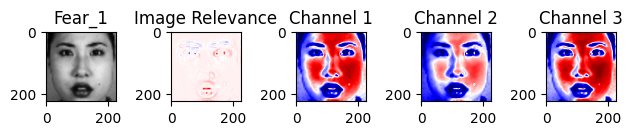

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  2
Contribution of pixels in the range [ 0.1 0.2 ] is :  3
Contribution of pixels in the range [ 0.2 0.3 ] is :  15
Contribution of pixels in the range [ 0.3 0.4 ] is :  75
Contribution of pixels in the range [ 0.4 0.5 ] is :  139974
Contribution of pixels in the range [ 0.5 0.6 ] is :  10250
Contribution of pixels in the range [ 0.6 0.7 ] is :  147
Contribution of pixels in the range [ 0.7 0.8 ] is :  40
Contribution of pixels in the range [ 0.8 0.9 ] is :  12
Contribution of pixels in the range [ 0.9 1.0 ] is :  9
Medium Fear
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Fear


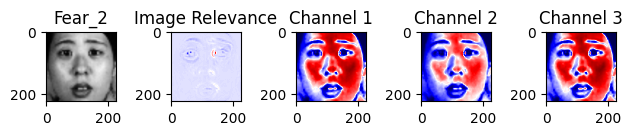

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  2
Contribution of pixels in the range [ 0.1 0.2 ] is :  4
Contribution of pixels in the range [ 0.2 0.3 ] is :  14
Contribution of pixels in the range [ 0.3 0.4 ] is :  99
Contribution of pixels in the range [ 0.4 0.5 ] is :  149587
Contribution of pixels in the range [ 0.5 0.6 ] is :  772
Contribution of pixels in the range [ 0.6 0.7 ] is :  28
Contribution of pixels in the range [ 0.7 0.8 ] is :  15
Contribution of pixels in the range [ 0.8 0.9 ] is :  0
Contribution of pixels in the range [ 0.9 1.0 ] is :  6
Medium Fear
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Neutral


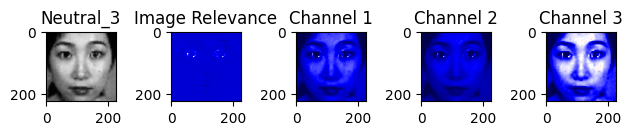

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  12
Contribution of pixels in the range [ 0.1 0.2 ] is :  10084
Contribution of pixels in the range [ 0.2 0.3 ] is :  140130
Contribution of pixels in the range [ 0.3 0.4 ] is :  236
Contribution of pixels in the range [ 0.4 0.5 ] is :  38
Contribution of pixels in the range [ 0.5 0.6 ] is :  13
Contribution of pixels in the range [ 0.6 0.7 ] is :  6
Contribution of pixels in the range [ 0.7 0.8 ] is :  6
Contribution of pixels in the range [ 0.8 0.9 ] is :  0
Contribution of pixels in the range [ 0.9 1.0 ] is :  2
Low Neutral
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Sadness


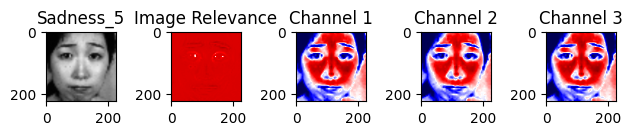

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  1
Contribution of pixels in the range [ 0.1 0.2 ] is :  0
Contribution of pixels in the range [ 0.2 0.3 ] is :  14
Contribution of pixels in the range [ 0.3 0.4 ] is :  6
Contribution of pixels in the range [ 0.4 0.5 ] is :  19
Contribution of pixels in the range [ 0.5 0.6 ] is :  28
Contribution of pixels in the range [ 0.6 0.7 ] is :  75
Contribution of pixels in the range [ 0.7 0.8 ] is :  1316
Contribution of pixels in the range [ 0.8 0.9 ] is :  148884
Contribution of pixels in the range [ 0.9 1.0 ] is :  184
High Sadness
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Surprise


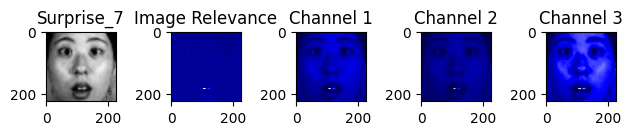

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  21581
Contribution of pixels in the range [ 0.1 0.2 ] is :  128753
Contribution of pixels in the range [ 0.2 0.3 ] is :  136
Contribution of pixels in the range [ 0.3 0.4 ] is :  30
Contribution of pixels in the range [ 0.4 0.5 ] is :  14
Contribution of pixels in the range [ 0.5 0.6 ] is :  6
Contribution of pixels in the range [ 0.6 0.7 ] is :  1
Contribution of pixels in the range [ 0.7 0.8 ] is :  3
Contribution of pixels in the range [ 0.8 0.9 ] is :  2
Contribution of pixels in the range [ 0.9 1.0 ] is :  1
Low Surprise
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Surprise


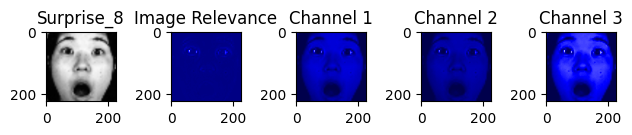

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  647
Contribution of pixels in the range [ 0.1 0.2 ] is :  149598
Contribution of pixels in the range [ 0.2 0.3 ] is :  187
Contribution of pixels in the range [ 0.3 0.4 ] is :  62
Contribution of pixels in the range [ 0.4 0.5 ] is :  18
Contribution of pixels in the range [ 0.5 0.6 ] is :  7
Contribution of pixels in the range [ 0.6 0.7 ] is :  4
Contribution of pixels in the range [ 0.7 0.8 ] is :  2
Contribution of pixels in the range [ 0.8 0.9 ] is :  1
Contribution of pixels in the range [ 0.9 1.0 ] is :  1
Low Surprise
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Neutral


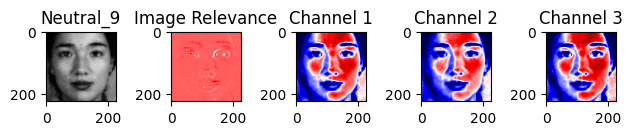

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  0
Contribution of pixels in the range [ 0.1 0.2 ] is :  1
Contribution of pixels in the range [ 0.2 0.3 ] is :  3
Contribution of pixels in the range [ 0.3 0.4 ] is :  7
Contribution of pixels in the range [ 0.4 0.5 ] is :  50
Contribution of pixels in the range [ 0.5 0.6 ] is :  1047
Contribution of pixels in the range [ 0.6 0.7 ] is :  149232
Contribution of pixels in the range [ 0.7 0.8 ] is :  175
Contribution of pixels in the range [ 0.8 0.9 ] is :  8
Contribution of pixels in the range [ 0.9 1.0 ] is :  4
Medium Neutral
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Neutral


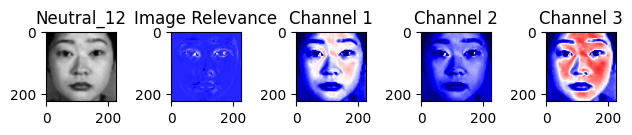

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  12
Contribution of pixels in the range [ 0.1 0.2 ] is :  87
Contribution of pixels in the range [ 0.2 0.3 ] is :  145564
Contribution of pixels in the range [ 0.3 0.4 ] is :  4643
Contribution of pixels in the range [ 0.4 0.5 ] is :  150
Contribution of pixels in the range [ 0.5 0.6 ] is :  39
Contribution of pixels in the range [ 0.6 0.7 ] is :  16
Contribution of pixels in the range [ 0.7 0.8 ] is :  10
Contribution of pixels in the range [ 0.8 0.9 ] is :  4
Contribution of pixels in the range [ 0.9 1.0 ] is :  2
Low Neutral
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Sadness


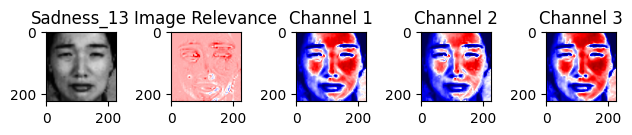

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  0
Contribution of pixels in the range [ 0.1 0.2 ] is :  2
Contribution of pixels in the range [ 0.2 0.3 ] is :  19
Contribution of pixels in the range [ 0.3 0.4 ] is :  244
Contribution of pixels in the range [ 0.4 0.5 ] is :  3514
Contribution of pixels in the range [ 0.5 0.6 ] is :  142699
Contribution of pixels in the range [ 0.6 0.7 ] is :  3721
Contribution of pixels in the range [ 0.7 0.8 ] is :  281
Contribution of pixels in the range [ 0.8 0.9 ] is :  37
Contribution of pixels in the range [ 0.9 1.0 ] is :  10
Medium Sadness
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Fear


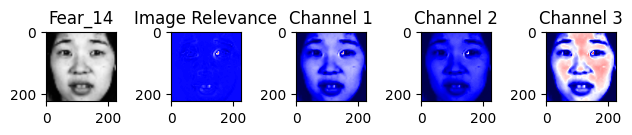

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  9
Contribution of pixels in the range [ 0.1 0.2 ] is :  60
Contribution of pixels in the range [ 0.2 0.3 ] is :  56258
Contribution of pixels in the range [ 0.3 0.4 ] is :  93968
Contribution of pixels in the range [ 0.4 0.5 ] is :  170
Contribution of pixels in the range [ 0.5 0.6 ] is :  35
Contribution of pixels in the range [ 0.6 0.7 ] is :  11
Contribution of pixels in the range [ 0.7 0.8 ] is :  7
Contribution of pixels in the range [ 0.8 0.9 ] is :  5
Contribution of pixels in the range [ 0.9 1.0 ] is :  4
Low Fear
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Happiness


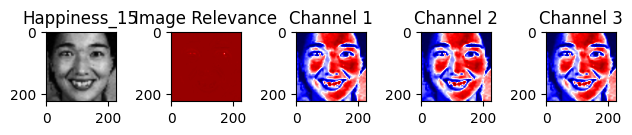

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  0
Contribution of pixels in the range [ 0.1 0.2 ] is :  0
Contribution of pixels in the range [ 0.2 0.3 ] is :  0
Contribution of pixels in the range [ 0.3 0.4 ] is :  2
Contribution of pixels in the range [ 0.4 0.5 ] is :  2
Contribution of pixels in the range [ 0.5 0.6 ] is :  4
Contribution of pixels in the range [ 0.6 0.7 ] is :  4
Contribution of pixels in the range [ 0.7 0.8 ] is :  20
Contribution of pixels in the range [ 0.8 0.9 ] is :  77
Contribution of pixels in the range [ 0.9 1.0 ] is :  150418
High Happiness
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Surprise


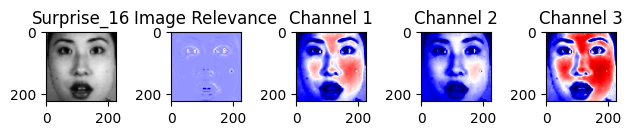

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  5
Contribution of pixels in the range [ 0.1 0.2 ] is :  11
Contribution of pixels in the range [ 0.2 0.3 ] is :  39
Contribution of pixels in the range [ 0.3 0.4 ] is :  593
Contribution of pixels in the range [ 0.4 0.5 ] is :  149525
Contribution of pixels in the range [ 0.5 0.6 ] is :  286
Contribution of pixels in the range [ 0.6 0.7 ] is :  43
Contribution of pixels in the range [ 0.7 0.8 ] is :  19
Contribution of pixels in the range [ 0.8 0.9 ] is :  4
Contribution of pixels in the range [ 0.9 1.0 ] is :  2
Medium Surprise
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Disgust


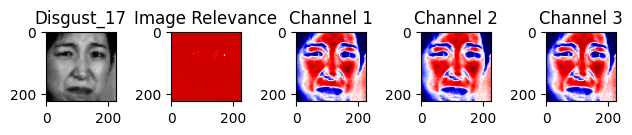

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  1
Contribution of pixels in the range [ 0.1 0.2 ] is :  0
Contribution of pixels in the range [ 0.2 0.3 ] is :  0
Contribution of pixels in the range [ 0.3 0.4 ] is :  5
Contribution of pixels in the range [ 0.4 0.5 ] is :  4
Contribution of pixels in the range [ 0.5 0.6 ] is :  23
Contribution of pixels in the range [ 0.6 0.7 ] is :  79
Contribution of pixels in the range [ 0.7 0.8 ] is :  5903
Contribution of pixels in the range [ 0.8 0.9 ] is :  144503
Contribution of pixels in the range [ 0.9 1.0 ] is :  9
High Disgust
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Surprise


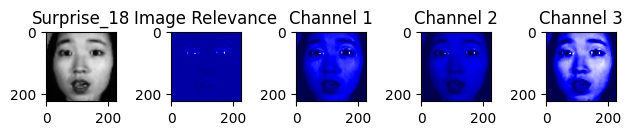

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  87
Contribution of pixels in the range [ 0.1 0.2 ] is :  148755
Contribution of pixels in the range [ 0.2 0.3 ] is :  1497
Contribution of pixels in the range [ 0.3 0.4 ] is :  103
Contribution of pixels in the range [ 0.4 0.5 ] is :  49
Contribution of pixels in the range [ 0.5 0.6 ] is :  18
Contribution of pixels in the range [ 0.6 0.7 ] is :  9
Contribution of pixels in the range [ 0.7 0.8 ] is :  4
Contribution of pixels in the range [ 0.8 0.9 ] is :  3
Contribution of pixels in the range [ 0.9 1.0 ] is :  2
Low Surprise
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Happiness


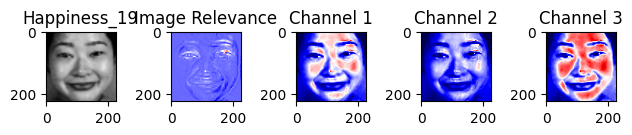

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  11
Contribution of pixels in the range [ 0.1 0.2 ] is :  150
Contribution of pixels in the range [ 0.2 0.3 ] is :  8820
Contribution of pixels in the range [ 0.3 0.4 ] is :  140047
Contribution of pixels in the range [ 0.4 0.5 ] is :  1252
Contribution of pixels in the range [ 0.5 0.6 ] is :  182
Contribution of pixels in the range [ 0.6 0.7 ] is :  40
Contribution of pixels in the range [ 0.7 0.8 ] is :  16
Contribution of pixels in the range [ 0.8 0.9 ] is :  6
Contribution of pixels in the range [ 0.9 1.0 ] is :  3
Low Happiness
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Happiness


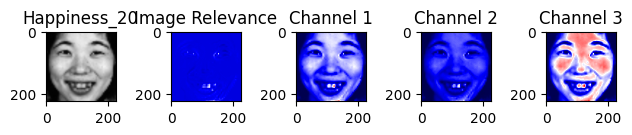

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  4
Contribution of pixels in the range [ 0.1 0.2 ] is :  98
Contribution of pixels in the range [ 0.2 0.3 ] is :  148007
Contribution of pixels in the range [ 0.3 0.4 ] is :  2165
Contribution of pixels in the range [ 0.4 0.5 ] is :  202
Contribution of pixels in the range [ 0.5 0.6 ] is :  44
Contribution of pixels in the range [ 0.6 0.7 ] is :  4
Contribution of pixels in the range [ 0.7 0.8 ] is :  2
Contribution of pixels in the range [ 0.8 0.9 ] is :  0
Contribution of pixels in the range [ 0.9 1.0 ] is :  1
Low Happiness
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Disgust


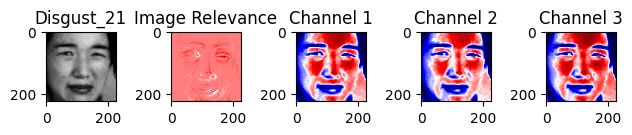

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  2
Contribution of pixels in the range [ 0.1 0.2 ] is :  1
Contribution of pixels in the range [ 0.2 0.3 ] is :  9
Contribution of pixels in the range [ 0.3 0.4 ] is :  14
Contribution of pixels in the range [ 0.4 0.5 ] is :  79
Contribution of pixels in the range [ 0.5 0.6 ] is :  1007
Contribution of pixels in the range [ 0.6 0.7 ] is :  147443
Contribution of pixels in the range [ 0.7 0.8 ] is :  1894
Contribution of pixels in the range [ 0.8 0.9 ] is :  65
Contribution of pixels in the range [ 0.9 1.0 ] is :  13
Medium Disgust
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Disgust


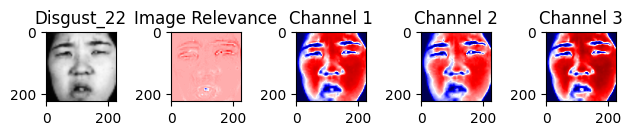

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  1
Contribution of pixels in the range [ 0.1 0.2 ] is :  1
Contribution of pixels in the range [ 0.2 0.3 ] is :  7
Contribution of pixels in the range [ 0.3 0.4 ] is :  26
Contribution of pixels in the range [ 0.4 0.5 ] is :  320
Contribution of pixels in the range [ 0.5 0.6 ] is :  147434
Contribution of pixels in the range [ 0.6 0.7 ] is :  2672
Contribution of pixels in the range [ 0.7 0.8 ] is :  60
Contribution of pixels in the range [ 0.8 0.9 ] is :  3
Contribution of pixels in the range [ 0.9 1.0 ] is :  3
Medium Disgust
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Happiness


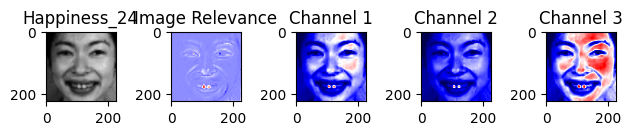

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  0
Contribution of pixels in the range [ 0.1 0.2 ] is :  3
Contribution of pixels in the range [ 0.2 0.3 ] is :  60
Contribution of pixels in the range [ 0.3 0.4 ] is :  144810
Contribution of pixels in the range [ 0.4 0.5 ] is :  5453
Contribution of pixels in the range [ 0.5 0.6 ] is :  145
Contribution of pixels in the range [ 0.6 0.7 ] is :  32
Contribution of pixels in the range [ 0.7 0.8 ] is :  12
Contribution of pixels in the range [ 0.8 0.9 ] is :  9
Contribution of pixels in the range [ 0.9 1.0 ] is :  3
Medium Happiness
-------------------------------------------------------------------------------------------------------


In [ ]:
# emotion_class = 'happy'  # Specify the emotion class for which you want to generate relevance scores

folder_path = '/content/drive/MyDrive/hm'
n = 1
image_names = []
positive = []
negative_counts = []
relevance_scores = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs).max(1).indices.detach().cpu().numpy()
    for i in range(inputs.shape[0]):
        image_id = i

        try:
            image_relevances = apply_lrp_on_vgg16(model, inputs[image_id])
            image_relevances = image_relevances.permute(0, 2, 3, 1).detach().cpu().numpy()[0]
            image_relevances = np.interp(image_relevances, (image_relevances.min(), image_relevances.max()), (0, 1))
            image_relevances_transposed = np.transpose(image_relevances, (2, 0, 1))
            pixel_relevance_scores = inputs[image_id].detach().cpu().numpy() * np.transpose(image_relevances, (2, 0, 1))

            pred_label = list(train_dataset.class_to_idx.keys())[list(train_dataset.class_to_idx.values()).index(labels[image_id])]
            image_name = pred_label + '_' + str(n)
            n += 1
            # Add condition to process images only for the specified emotion class
            # if pred_label == emotion_class:
            if outputs[image_id] == labels[image_id]:
                print("Groundtruth for this image:", pred_label)
                plt.clf()  # Clear the previous figure

                plt.subplot(1, 5, 1)
                plt.imshow(inputs[image_id].permute(1, 2, 0).detach().cpu().numpy())
                plt.title(image_name)

                plt.subplot(1, 5, 2)
                plt.imshow(image_relevances[:, :, 0], cmap="seismic")
                plt.title("Image Relevance")

                plt.subplot(1, 5, 3)
                plt.imshow(pixel_relevance_scores[0], cmap="seismic")
                plt.title("Channel 1")

                plt.subplot(1, 5, 4)
                plt.imshow(pixel_relevance_scores[1], cmap="seismic")
                plt.title("Channel 2")

                plt.subplot(1, 5, 5)
                plt.imshow(pixel_relevance_scores[2], cmap="seismic")
                plt.title("Channel 3")

                plt.tight_layout()
                plt.show()

                # p, z = contributed_pixels_count(1, pixel_relevance_scores)
                image_names.append(image_name)
                # positive_counts.append(p)
                # negative_counts.append(z)
                relevance_scores.append(image_relevances)
                print("-------------------------------------------------------------------------------------------------------")
                # print((image_relevances.shape))
                intensity = calculate_range_by_mean5(image_relevances)
                print(intensity+" "+pred_label)
                print("-------------------------------------------------------------------------------------------------------")

        except TypeError:
            continue


In [ ]:
!pip install PyPDF2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 2.4 MB/s eta 0:00:00


In [ ]:
from PyPDF2 import PdfPages

ImportError: cannot import name 'PdfPages' from 'PyPDF2' (/usr/local/lib/python3.10/dist-packages/PyPDF2/__init__.py)

In [ ]:
# Create a PDF file to save the plots
pdf_path = '/content/drive/MyDrive/hm/output_plots.pdf'
pdf = PdfPages(pdf_path)

In [ ]:
import matplotlib.pyplot as plt

# Create a PDF file to save the plots
pdf_path = '/content/drive/MyDrive/hm/output_plots.pdf'
pdf = plt.PdfPages(pdf_path)

# Iterate over the data and save each plot to the PDF file
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs).max(1).indices.detach().cpu().numpy()
    for i in range(inputs.shape[0]):
        image_id = i

        try:
            image_relevances = apply_lrp_on_vgg16(model, inputs[image_id])
            image_relevances = image_relevances.permute(0, 2, 3, 1).detach().cpu().numpy()[0]
            image_relevances = np.interp(image_relevances, (image_relevances.min(), image_relevances.max()), (0, 1))
            image_relevances_transposed = np.transpose(image_relevances, (2, 0, 1))
            pixel_relevance_scores = inputs[image_id].detach().cpu().numpy() * np.transpose(image_relevances, (2, 0, 1))

            pred_label = list(train_dataset.class_to_idx.keys())[list(train_dataset.class_to_idx.values()).index(labels[image_id])]
            image_name = pred_label + '_' + str(n)
            n += 1
            # Add condition to process images only for the specified emotion class
            # if pred_label == emotion_class:
            if outputs[image_id] == labels[image_id]:
                print("Groundtruth for this image:", pred_label)
                plt.clf()  # Clear the previous figure

                plt.subplot(1, 5, 1)
                plt.imshow(inputs[image_id].permute(1, 2, 0).detach().cpu().numpy())
                plt.title(image_name)

                plt.subplot(1, 5, 2)
                plt.imshow(image_relevances[:, :, 0], cmap="seismic")
                plt.title("Image Relevance")

                plt.subplot(1, 5, 3)
                plt.imshow(pixel_relevance_scores[0], cmap="seismic")
                plt.title("Channel 1")

                plt.subplot(1, 5, 4)
                plt.imshow(pixel_relevance_scores[1], cmap="seismic")
                plt.title("Channel 2")

                plt.subplot(1, 5, 5)
                plt.imshow(pixel_relevance_scores[2], cmap="seismic")
                plt.title("Channel 3")

                plt.tight_layout()

                # Save the current figure to the PDF file
                pdf.savefig()

                # Close the current figure
                plt.close()

                # p, z = contributed_pixels_count(1, pixel_relevance_scores)
                image_names.append(image_name)
                # positive_counts.append(p)
                # negative_counts.append(z)
                relevance_scores.append(image_relevances)
                print("-------------------------------------------------------------------------------------------------------")
                # print((image_relevances.shape))
                intensity = calculate_range_by_mean5(image_relevances)
                print(intensity+" "+pred_label)
                print("-------------------------------------------------------------------------------------------------------")

        except TypeError:
            continue

# Close the PDF file
pdf.close()


AttributeError: module 'matplotlib.pyplot' has no attribute 'PdfPages'

#### Trial

In [ ]:
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Example: Encode a sample image to base64
def conv_base64(image_data):
    plt.imshow(image_data)
    plt.axis('off')

    # Save the plot to BytesIO buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)

    # Encode the image to base64
    base64_image = base64.b64encode(buffer.read()).decode('utf-8')
    return base64_image

In [ ]:
from IPython.display import display, HTML
from tabulate import tabulate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

n = 1

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs).max(1).indices.detach().cpu().numpy()
    for i in range(inputs.shape[0]):
        single_data = []
        image_id = i
        try:
            image_relevances = apply_lrp_on_vgg16(model, inputs[image_id])
            image_relevances = image_relevances.permute(0, 2, 3, 1).detach().cpu().numpy()[0]
            image_relevances = np.interp(image_relevances, (image_relevances.min(), image_relevances.max()), (0, 1))
            image_relevances_transposed = np.transpose(image_relevances, (2, 0, 1))
            pixel_relevance_scores = inputs[image_id].detach().cpu().numpy() * np.transpose(image_relevances, (2, 0, 1))

            pred_label = list(train_dataset.class_to_idx.keys())[list(train_dataset.class_to_idx.values()).index(labels[image_id])]
            image_name = pred_label + '_' + str(n)
            n += 1
            if outputs[image_id] == labels[image_id]:
                # print("Groundtruth for this image:", pred_label)
                intensity = calculate_range_by_mean5(image_relevances)

                single_data.append("<img src='data:image/png;base64,{}' />".format(conv_base64(inputs[image_id])))
                single_data.append(image_relevances)
                single_data.append("<table><tr><td>Inner Table 1</td><td>Inner Table 2</td></tr></table>")
                single_data.append("intensity")
                # my_table = HTML(tabulate(data, headers=["Image", "Relevance Scores", "Separation", "Counts"], tablefmt='html'))

                df = pd.DataFrame([single_data], columns=["Image", "Relevance Scores", "Inner Table", "Counts"])

                # Display the DataFrame as a table
                df_html = HTML(df.to_html(escape=False, index=False))
                display(df_html)


        except TypeError:
            continue


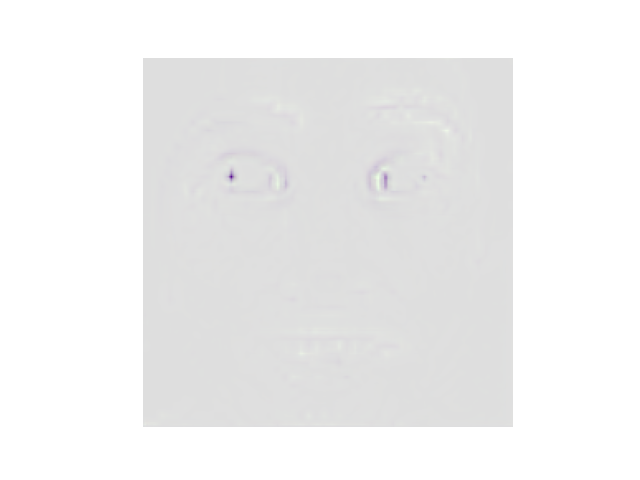

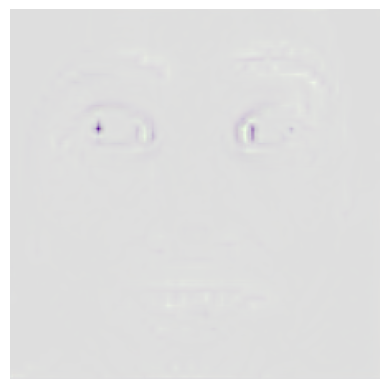

In [ ]:
from IPython.display import HTML

# Example data
single_data = []
single_data.append("<img src='data:image/png;base64,{}' />".format(conv_base64(image_relevances)))
single_data.append(image_relevances)
single_data.append("<table><tr><td>Inner Table 1</td><td>Inner Table 2</td></tr></table>")
single_data.append("intensity")

# Create HTML code
html_code = """
<table>
  <tr>
    <td>{}</td>
    <td>{}</td>
  </tr>
  <tr>
    <td>{}</td>
    <td>{}</td>
  </tr>
</table>
""".format(*single_data)

# Display the HTML code
HTML(html_code)

Groundtruth for this image: Sadness


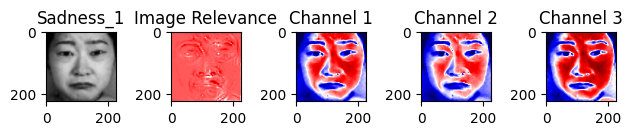

[[[0.67091397 0.67091397 0.67091397]
  [0.67091397 0.67091397 0.67091397]
  [0.67091397 0.67091397 0.67091397]
  ...
  [0.67386765 0.67700613 0.67506621]
  [0.67688613 0.67955378 0.67608081]
  [0.6717344  0.67569273 0.67801088]]

 [[0.67091397 0.67091397 0.67091397]
  [0.67091397 0.67091397 0.67091397]
  [0.67091397 0.67091397 0.67091397]
  ...
  [0.68650497 0.6861974  0.67085717]
  [0.69525441 0.69478326 0.67474617]
  [0.67990475 0.68309776 0.67769708]]

 [[0.67091397 0.67091397 0.67091397]
  [0.67091397 0.67091397 0.67091397]
  [0.67091397 0.67091397 0.67091397]
  ...
  [0.69047955 0.68807568 0.66538354]
  [0.69244349 0.68783081 0.66629575]
  [0.68133689 0.68207437 0.67390357]]

 ...

 [[0.67373064 0.66939893 0.67156842]
  [0.69344999 0.68797195 0.67194738]
  [0.68736192 0.66863513 0.66411204]
  ...
  [0.61886102 0.60813747 0.63762568]
  [0.58927358 0.59782969 0.64376146]
  [0.55508338 0.55137358 0.60283439]]

 [[0.70314925 0.72188543 0.69748636]
  [0.72558219 0.74521763 0.70167209]


In [ ]:
# emotion_class = 'happy'  # Specify the emotion class for which you want to generate relevance scores

folder_path = '/content/drive/MyDrive/hm'
n = 1
image_names = []
positive = []
negative_counts = []
relevance_scores = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs).max(1).indices.detach().cpu().numpy()
    for i in range(inputs.shape[0]):
        if n<=1:
            image_id = i

            try:
                image_relevances = apply_lrp_on_vgg16(model, inputs[image_id])
                image_relevances = image_relevances.permute(0, 2, 3, 1).detach().cpu().numpy()[0]
                image_relevances = np.interp(image_relevances, (image_relevances.min(), image_relevances.max()), (0, 1))
                image_relevances_transposed = np.transpose(image_relevances, (2, 0, 1))
                pixel_relevance_scores = inputs[image_id].detach().cpu().numpy() * np.transpose(image_relevances, (2, 0, 1))

                pred_label = list(train_dataset.class_to_idx.keys())[list(train_dataset.class_to_idx.values()).index(labels[image_id])]
                image_name = pred_label + '_' + str(n)
                n += 1
                # Add condition to process images only for the specified emotion class
                # if pred_label == emotion_class:
                if outputs[image_id] == labels[image_id]:
                    print("Groundtruth for this image:", pred_label)
                    plt.clf()  # Clear the previous figure

                    plt.subplot(1, 5, 1)
                    plt.imshow(inputs[image_id].permute(1, 2, 0).detach().cpu().numpy())
                    plt.title(image_name)

                    plt.subplot(1, 5, 2)
                    plt.imshow(image_relevances[:, :, 0], cmap="seismic")
                    plt.title("Image Relevance")

                    plt.subplot(1, 5, 3)
                    plt.imshow(pixel_relevance_scores[0], cmap="seismic")
                    plt.title("Channel 1")

                    plt.subplot(1, 5, 4)
                    plt.imshow(pixel_relevance_scores[1], cmap="seismic")
                    plt.title("Channel 2")

                    plt.subplot(1, 5, 5)
                    plt.imshow(pixel_relevance_scores[2], cmap="seismic")
                    plt.title("Channel 3")

                    plt.tight_layout()
                    plt.show()

                    # p, z = contributed_pixels_count(1, pixel_relevance_scores)
                    image_names.append(image_name)
                    # positive_counts.append(p)
                    # negative_counts.append(z)
                    print(image_relevances)
                    relevance_scores.append(image_relevances)

                    print("-------------------------------------------------------------------------------------------------------")
                    # print((image_relevances.shape))
                    intensity = calculate_range_by_mean5(image_relevances)
                    print(intensity+" "+pred_label)
                    print("-------------------------------------------------------------------------------------------------------")

            except TypeError:
                continue


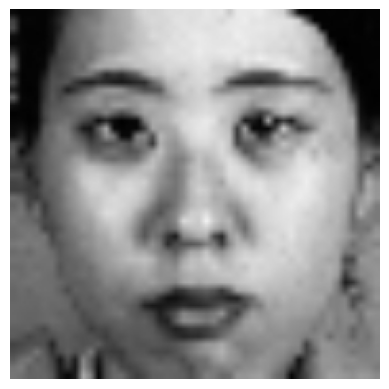

In [ ]:
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# Example: Encode a sample image to base64
# image_data = np.random.rand(3, 3)  # Replace this with your actual image data
image_path = "/content/jtest_dir/Anger/Images13.jpeg"

pil_image = Image.open(image_path).convert("RGB")

plt.imshow(pil_image)
plt.axis('off')

# Save the plot to BytesIO buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Encode the image to base64
base64_image = base64.b64encode(buffer.read()).decode('utf-8')

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def predict_and_apply_lrp(model, input_image):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    with torch.no_grad():
        input_image = input_image.unsqueeze(0).to(device)
        output = model(input_image)
        predicted_label = torch.argmax(output).item()

        try:
            image_relevances = apply_lrp_on_vgg16(model, input_image)
            image_relevances = image_relevances.permute(0, 2, 3, 1).cpu().numpy()[0]
            image_relevances = np.interp(image_relevances, (image_relevances.min(), image_relevances.max()), (0, 1))
            image_relevances_transposed = np.transpose(image_relevances, (2, 0, 1))
            pixel_relevance_scores = input_image.cpu().numpy() * np.transpose(image_relevances, (2, 0, 1))

            image_name = f"predicted_{predicted_label}"

            plt.subplot(1, 4, 1)
            plt.imshow(input_image[0].permute(1, 2, 0).cpu().numpy())
            plt.title(image_name)

            plt.subplot(1, 4, 2)
            plt.imshow(image_relevances[:, :, 0], cmap="seismic")
            plt.title("Image Relevance")

            plt.subplot(1, 4, 3)
            plt.imshow(pixel_relevance_scores[0, 0], cmap="seismic")
            plt.title("Channel 1")

            plt.subplot(1, 4, 4)
            plt.imshow(pixel_relevance_scores[0, 1], cmap="seismic")
            plt.title("Channel 2")

            plt.tight_layout()
            plt.show()

            relevance_scores = {
                "image_name": image_name,
                "predicted_label": predicted_label,
                "image_relevances": image_relevances,
            }

            return relevance_scores

        except TypeError:
            print("Error in LRP application.")
            return None


In [ ]:
from torchvision import transforms
from PIL import Image

def load_image_and_transform(image_path, expected_input_size):
    # Load the image from file
    pil_image = Image.open(image_path).convert("RGB")

    # Resize the image to match the expected input size
    transform = transforms.Compose([
        transforms.Resize(expected_input_size),
        transforms.ToTensor(),
    ])

    # Apply the defined transformation
    input_image = transform(pil_image)

    return input_image

# Example usage
image_path = "/content/jtest_dir/Anger/Images13.jpeg"
expected_input_size = (224, 224)  # Adjust based on your model's expected input size
input_image = load_image_and_transform(image_path, expected_input_size)

result = predict_and_apply_lrp(model, input_image)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 3, 224, 224]

In [ ]:
print(pixel_relevance_scores[-1])
count = len(pixel_relevance_scores[-1])
print("Count of elements in the last element:", count)

for i in pixel_relevance_scores[-1]:
  print(i)

In [ ]:
print(len(pixel_relevance_scores))
print(pixel_relevance_scores.shape)
print(image_relevances.shape)

3
(3, 224, 224)
(224, 224, 3)


In [ ]:
for i in image_relevances[0]:
  print(i)

print(len(image_relevances[0]))
print(len(image_relevances[1]))
print(len(image_relevances[2]))


[0.71051669 0.72172245 0.7088229 ]
[0.73245346 0.75326783 0.71746319]
[0.73092587 0.74391834 0.71125859]
[0.72454571 0.7341207  0.70876743]
[0.71881088 0.72760409 0.70693922]
[0.7173827  0.72407818 0.70558989]
[0.71930038 0.72482294 0.70602538]
[0.71853585 0.72394667 0.70566426]
[0.71761921 0.72360676 0.70576894]
[0.71798766 0.72458253 0.70609466]
[0.71926526 0.72708416 0.70718438]
[0.72038229 0.7290562  0.7082997 ]
[0.72110563 0.73036875 0.70914143]
[0.72635514 0.73925798 0.71278357]
[0.73380794 0.75042713 0.71704527]
[0.74629641 0.76832444 0.72416969]
[0.75360943 0.77912318 0.72893256]
[0.73818718 0.75538312 0.72242984]
[0.72584518 0.73651086 0.71651046]
[0.71489627 0.71880516 0.71042552]
[0.70171528 0.70025209 0.70240384]
[0.69813965 0.69632222 0.70004577]
[0.6988455  0.69776475 0.70012314]
[0.69962001 0.69929352 0.70020712]
[0.70000524 0.70000851 0.70037867]
[0.70003335 0.70004015 0.70024575]
[0.70003286 0.70000061 0.70017407]
[0.70009474 0.70006562 0.70018587]
[0.70013539 0.700096

In [ ]:
# Define the contributions and ranges
contributions = [10, 1498, 148648, 291, 40, 24, 7, 6, 0, 3]
ranges = [(0.0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5),
          (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]

# Calculate total contribution
total_contribution = sum(contributions)

# Calculate weighted means for each range
weighted_means = []
for i, (lower, upper) in enumerate(ranges):
    midpoint = (lower + upper) / 2
    weight = contributions[i] / total_contribution
    weighted_means.append(midpoint * weight)

# Identify the maximum weighted mean and assign intensity category
max_index = weighted_means.index(max(weighted_means))
if max_index == 0:
    intensity_category = "Low"
elif max_index == 1:
    intensity_category = "Medium"
else:
    intensity_category = "High"

print("Intensity Category:", intensity_category)


Intensity Category: High


In [ ]:
# Define the contributions and ranges
contributions = [1, 5, 4, 13, 21, 72, 301, 37960, 112099, 51]
ranges = [(0.0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5),
          (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]

# Calculate total contribution
total_contribution = sum(contributions)

# Calculate weighted means for each range
weighted_means = []
for i, (lower, upper) in enumerate(ranges):
    midpoint = (lower + upper) / 2
    weight = contributions[i] / total_contribution
    weighted_means.append(midpoint * weight)

# Identify the maximum weighted mean and assign intensity category
max_index = weighted_means.index(max(weighted_means))
if max_index == 0:
    intensity_category = "Low"
elif max_index == 1:
    intensity_category = "Medium"
else:
    intensity_category = "High"

print("Intensity Category:", intensity_category)


Intensity Category: High


In [ ]:
# Define the contributions and ranges
contributions = [1, 5, 4, 13, 21, 72, 301, 37960, 112099, 51]
ranges = [(0.0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5),
          (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]

# Calculate means for three regions: 0-5, middle 5, last 5
mean1 = sum(contributions[:5]) / 5
mean2 = sum(contributions[5:7]) / 2
mean3 = sum(contributions[7:]) / 3

# Determine the maximum mean and assign intensity category
max_mean = max(mean1, mean2, mean3)
if max_mean == mean1:
    intensity_category = "LOW"
elif max_mean == mean2:
    intensity_category = "MEDIUM"
else:
    intensity_category = "HIGH"

print("Intensity Category based on maximum mean:", intensity_category)


Intensity Category based on maximum mean: HIGH


In [ ]:
#using Quartile
# Define the contributions and ranges
contributions = [1, 5, 4, 13, 21, 72, 301, 37960, 112099, 51]

# Calculate quantiles to divide the data into three equal-sized subsets
n = len(contributions)
subset_size = n // 3
quantiles = [contributions[i * subset_size:(i + 1) * subset_size] for i in range(3)]

# Calculate the sum of contributions in each subset
subset_sums = [sum(subset) for subset in quantiles]

# Determine the intensity category based on the concentration of data within subsets
max_subset_sum = max(subset_sums)
if max_subset_sum == subset_sums[0]:
    intensity_category = "LOW"
elif max_subset_sum == subset_sums[1]:
    intensity_category = "MEDIUM"
else:
    intensity_category = "HIGH"

print("Intensity Category based on quantiles:", intensity_category)


Intensity Category based on quantiles: HIGH


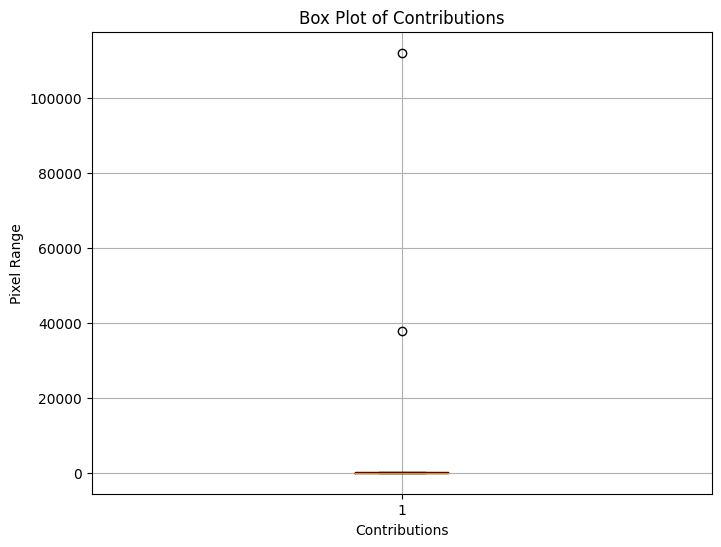

In [ ]:
import matplotlib.pyplot as plt

# Define the contributions
contributions = [1, 5, 4, 13, 21, 72, 301, 37960, 112099, 51]

# Create a box plot
plt.figure(figsize=(8, 6))
plt.boxplot(contributions)
plt.title("Box Plot of Contributions")
plt.xlabel("Contributions")
plt.ylabel("Pixel Range")
plt.grid(True)
plt.show()


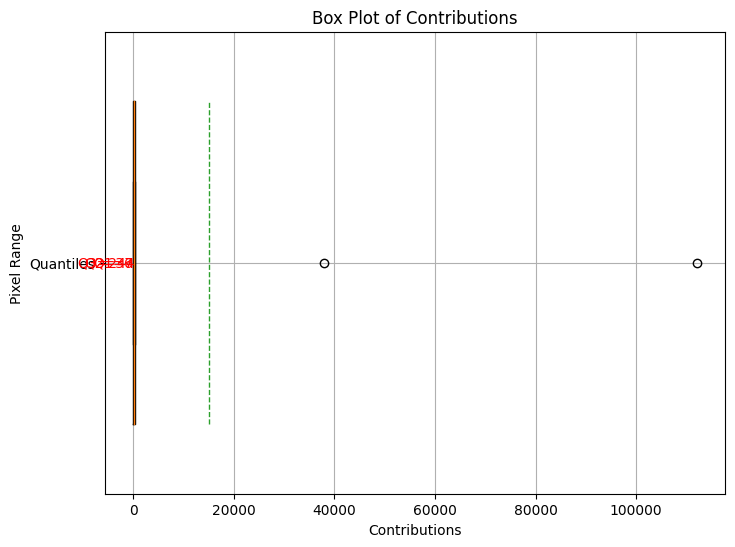

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the contributions
contributions = [1, 5, 4, 13, 21, 72, 301, 37960, 112099, 51]

# Calculate quantiles
quantiles = np.percentile(contributions, [25, 50, 75])

# Create a modified box plot
plt.figure(figsize=(8, 6))
plt.boxplot(contributions, vert=False, widths=0.7, showmeans=True, meanline=True)
plt.title("Box Plot of Contributions")
plt.xlabel("Contributions")
plt.ylabel("Pixel Range")
plt.yticks([1], ["Quantiles"])
plt.grid(True)

# Annotate quantile values
for i, quantile in enumerate(quantiles):
    plt.text(quantile, 1, f'Q{i+1}={quantile:.0f}', ha='right', va='center', color='red')

plt.show()


Groundtruth for this image: Surprise


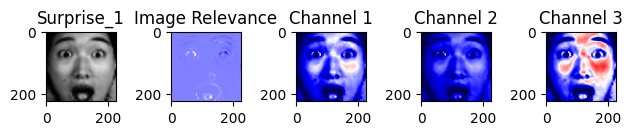

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  1
Contribution of pixels in the range [ 0.1 0.2 ] is :  9
Contribution of pixels in the range [ 0.2 0.3 ] is :  67
Contribution of pixels in the range [ 0.3 0.4 ] is :  149266
Contribution of pixels in the range [ 0.4 0.5 ] is :  1116
Contribution of pixels in the range [ 0.5 0.6 ] is :  51
Contribution of pixels in the range [ 0.6 0.7 ] is :  13
Contribution of pixels in the range [ 0.7 0.8 ] is :  3
Contribution of pixels in the range [ 0.8 0.9 ] is :  0
Contribution of pixels in the range [ 0.9 1.0 ] is :  1
Low Surprise
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Disgust


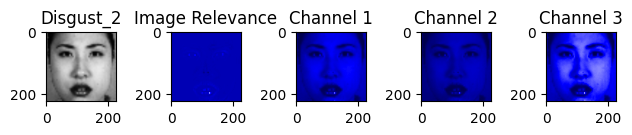

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  50
Contribution of pixels in the range [ 0.1 0.2 ] is :  150139
Contribution of pixels in the range [ 0.2 0.3 ] is :  294
Contribution of pixels in the range [ 0.3 0.4 ] is :  30
Contribution of pixels in the range [ 0.4 0.5 ] is :  9
Contribution of pixels in the range [ 0.5 0.6 ] is :  0
Contribution of pixels in the range [ 0.6 0.7 ] is :  4
Contribution of pixels in the range [ 0.7 0.8 ] is :  0
Contribution of pixels in the range [ 0.8 0.9 ] is :  0
Contribution of pixels in the range [ 0.9 1.0 ] is :  1
Low Disgust
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Sadness


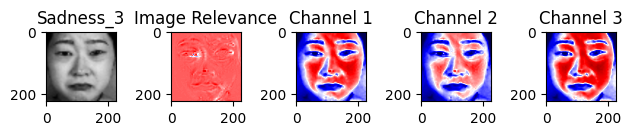

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  0
Contribution of pixels in the range [ 0.1 0.2 ] is :  3
Contribution of pixels in the range [ 0.2 0.3 ] is :  6
Contribution of pixels in the range [ 0.3 0.4 ] is :  72
Contribution of pixels in the range [ 0.4 0.5 ] is :  364
Contribution of pixels in the range [ 0.5 0.6 ] is :  13867
Contribution of pixels in the range [ 0.6 0.7 ] is :  135870
Contribution of pixels in the range [ 0.7 0.8 ] is :  315
Contribution of pixels in the range [ 0.8 0.9 ] is :  24
Contribution of pixels in the range [ 0.9 1.0 ] is :  6
Medium Sadness
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Neutral


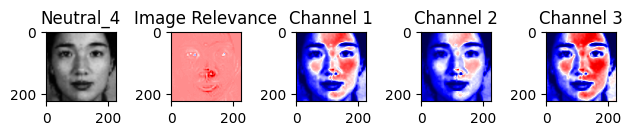

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  2
Contribution of pixels in the range [ 0.1 0.2 ] is :  4
Contribution of pixels in the range [ 0.2 0.3 ] is :  12
Contribution of pixels in the range [ 0.3 0.4 ] is :  19
Contribution of pixels in the range [ 0.4 0.5 ] is :  77
Contribution of pixels in the range [ 0.5 0.6 ] is :  2184
Contribution of pixels in the range [ 0.6 0.7 ] is :  147569
Contribution of pixels in the range [ 0.7 0.8 ] is :  577
Contribution of pixels in the range [ 0.8 0.9 ] is :  73
Contribution of pixels in the range [ 0.9 1.0 ] is :  10
Medium Neutral
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Fear


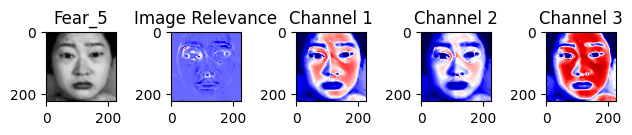

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  8
Contribution of pixels in the range [ 0.1 0.2 ] is :  87
Contribution of pixels in the range [ 0.2 0.3 ] is :  797
Contribution of pixels in the range [ 0.3 0.4 ] is :  138985
Contribution of pixels in the range [ 0.4 0.5 ] is :  9939
Contribution of pixels in the range [ 0.5 0.6 ] is :  574
Contribution of pixels in the range [ 0.6 0.7 ] is :  97
Contribution of pixels in the range [ 0.7 0.8 ] is :  28
Contribution of pixels in the range [ 0.8 0.9 ] is :  7
Contribution of pixels in the range [ 0.9 1.0 ] is :  5
Low Fear
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Neutral


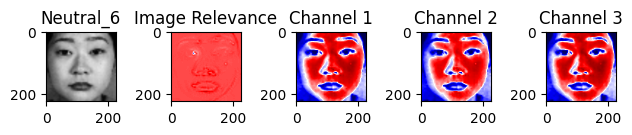

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  0
Contribution of pixels in the range [ 0.1 0.2 ] is :  4
Contribution of pixels in the range [ 0.2 0.3 ] is :  3
Contribution of pixels in the range [ 0.3 0.4 ] is :  7
Contribution of pixels in the range [ 0.4 0.5 ] is :  22
Contribution of pixels in the range [ 0.5 0.6 ] is :  72
Contribution of pixels in the range [ 0.6 0.7 ] is :  140693
Contribution of pixels in the range [ 0.7 0.8 ] is :  9635
Contribution of pixels in the range [ 0.8 0.9 ] is :  83
Contribution of pixels in the range [ 0.9 1.0 ] is :  8
High Neutral
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Fear


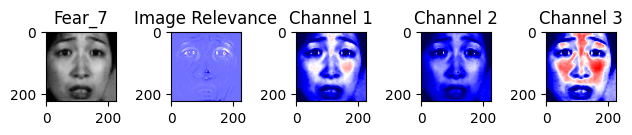

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  3
Contribution of pixels in the range [ 0.1 0.2 ] is :  13
Contribution of pixels in the range [ 0.2 0.3 ] is :  136
Contribution of pixels in the range [ 0.3 0.4 ] is :  148024
Contribution of pixels in the range [ 0.4 0.5 ] is :  2170
Contribution of pixels in the range [ 0.5 0.6 ] is :  131
Contribution of pixels in the range [ 0.6 0.7 ] is :  31
Contribution of pixels in the range [ 0.7 0.8 ] is :  10
Contribution of pixels in the range [ 0.8 0.9 ] is :  3
Contribution of pixels in the range [ 0.9 1.0 ] is :  6
Medium Fear
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Happiness


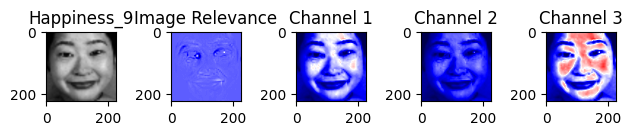

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  21
Contribution of pixels in the range [ 0.1 0.2 ] is :  188
Contribution of pixels in the range [ 0.2 0.3 ] is :  15613
Contribution of pixels in the range [ 0.3 0.4 ] is :  134652
Contribution of pixels in the range [ 0.4 0.5 ] is :  42
Contribution of pixels in the range [ 0.5 0.6 ] is :  7
Contribution of pixels in the range [ 0.6 0.7 ] is :  1
Contribution of pixels in the range [ 0.7 0.8 ] is :  2
Contribution of pixels in the range [ 0.8 0.9 ] is :  0
Contribution of pixels in the range [ 0.9 1.0 ] is :  1
Low Happiness
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Surprise


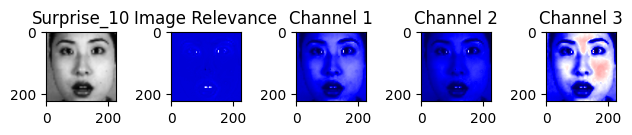

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  19
Contribution of pixels in the range [ 0.1 0.2 ] is :  121820
Contribution of pixels in the range [ 0.2 0.3 ] is :  28396
Contribution of pixels in the range [ 0.3 0.4 ] is :  190
Contribution of pixels in the range [ 0.4 0.5 ] is :  47
Contribution of pixels in the range [ 0.5 0.6 ] is :  27
Contribution of pixels in the range [ 0.6 0.7 ] is :  12
Contribution of pixels in the range [ 0.7 0.8 ] is :  7
Contribution of pixels in the range [ 0.8 0.9 ] is :  6
Contribution of pixels in the range [ 0.9 1.0 ] is :  3
Low Surprise
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Sadness


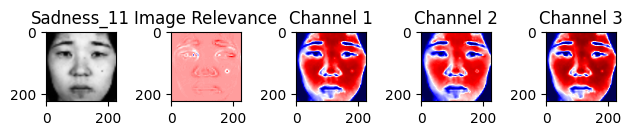

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  2
Contribution of pixels in the range [ 0.1 0.2 ] is :  3
Contribution of pixels in the range [ 0.2 0.3 ] is :  13
Contribution of pixels in the range [ 0.3 0.4 ] is :  72
Contribution of pixels in the range [ 0.4 0.5 ] is :  1943
Contribution of pixels in the range [ 0.5 0.6 ] is :  148079
Contribution of pixels in the range [ 0.6 0.7 ] is :  406
Contribution of pixels in the range [ 0.7 0.8 ] is :  5
Contribution of pixels in the range [ 0.8 0.9 ] is :  3
Contribution of pixels in the range [ 0.9 1.0 ] is :  1
Medium Sadness
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Happiness


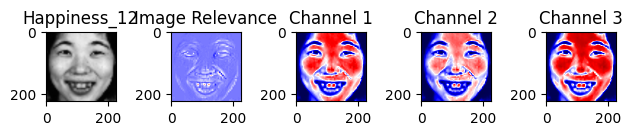

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  3
Contribution of pixels in the range [ 0.1 0.2 ] is :  13
Contribution of pixels in the range [ 0.2 0.3 ] is :  43
Contribution of pixels in the range [ 0.3 0.4 ] is :  1878
Contribution of pixels in the range [ 0.4 0.5 ] is :  147355
Contribution of pixels in the range [ 0.5 0.6 ] is :  1168
Contribution of pixels in the range [ 0.6 0.7 ] is :  57
Contribution of pixels in the range [ 0.7 0.8 ] is :  8
Contribution of pixels in the range [ 0.8 0.9 ] is :  1
Contribution of pixels in the range [ 0.9 1.0 ] is :  1
Medium Happiness
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Surprise


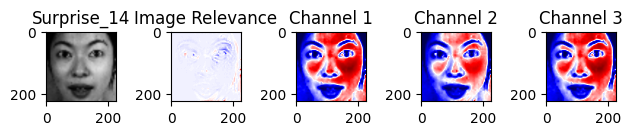

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  1
Contribution of pixels in the range [ 0.1 0.2 ] is :  5
Contribution of pixels in the range [ 0.2 0.3 ] is :  16
Contribution of pixels in the range [ 0.3 0.4 ] is :  120
Contribution of pixels in the range [ 0.4 0.5 ] is :  45499
Contribution of pixels in the range [ 0.5 0.6 ] is :  104743
Contribution of pixels in the range [ 0.6 0.7 ] is :  125
Contribution of pixels in the range [ 0.7 0.8 ] is :  13
Contribution of pixels in the range [ 0.8 0.9 ] is :  3
Contribution of pixels in the range [ 0.9 1.0 ] is :  2
Medium Surprise
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Surprise


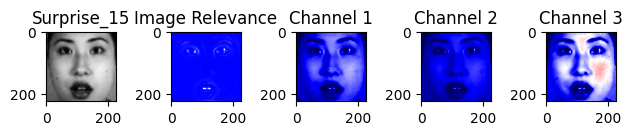

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  6
Contribution of pixels in the range [ 0.1 0.2 ] is :  97
Contribution of pixels in the range [ 0.2 0.3 ] is :  149586
Contribution of pixels in the range [ 0.3 0.4 ] is :  687
Contribution of pixels in the range [ 0.4 0.5 ] is :  96
Contribution of pixels in the range [ 0.5 0.6 ] is :  33
Contribution of pixels in the range [ 0.6 0.7 ] is :  12
Contribution of pixels in the range [ 0.7 0.8 ] is :  8
Contribution of pixels in the range [ 0.8 0.9 ] is :  1
Contribution of pixels in the range [ 0.9 1.0 ] is :  1
Low Surprise
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Disgust


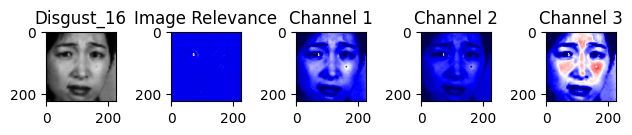

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  3
Contribution of pixels in the range [ 0.1 0.2 ] is :  16
Contribution of pixels in the range [ 0.2 0.3 ] is :  149606
Contribution of pixels in the range [ 0.3 0.4 ] is :  835
Contribution of pixels in the range [ 0.4 0.5 ] is :  33
Contribution of pixels in the range [ 0.5 0.6 ] is :  16
Contribution of pixels in the range [ 0.6 0.7 ] is :  8
Contribution of pixels in the range [ 0.7 0.8 ] is :  4
Contribution of pixels in the range [ 0.8 0.9 ] is :  2
Contribution of pixels in the range [ 0.9 1.0 ] is :  4
Low Disgust
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Disgust


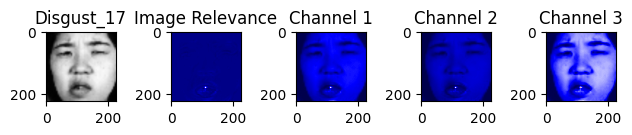

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  381
Contribution of pixels in the range [ 0.1 0.2 ] is :  149893
Contribution of pixels in the range [ 0.2 0.3 ] is :  199
Contribution of pixels in the range [ 0.3 0.4 ] is :  31
Contribution of pixels in the range [ 0.4 0.5 ] is :  13
Contribution of pixels in the range [ 0.5 0.6 ] is :  2
Contribution of pixels in the range [ 0.6 0.7 ] is :  5
Contribution of pixels in the range [ 0.7 0.8 ] is :  1
Contribution of pixels in the range [ 0.8 0.9 ] is :  0
Contribution of pixels in the range [ 0.9 1.0 ] is :  2
Low Disgust
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Sadness


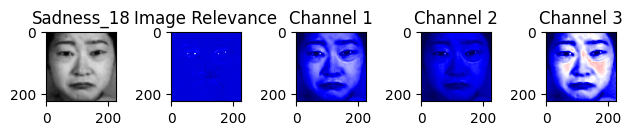

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  25
Contribution of pixels in the range [ 0.1 0.2 ] is :  140434
Contribution of pixels in the range [ 0.2 0.3 ] is :  9960
Contribution of pixels in the range [ 0.3 0.4 ] is :  70
Contribution of pixels in the range [ 0.4 0.5 ] is :  18
Contribution of pixels in the range [ 0.5 0.6 ] is :  8
Contribution of pixels in the range [ 0.6 0.7 ] is :  6
Contribution of pixels in the range [ 0.7 0.8 ] is :  4
Contribution of pixels in the range [ 0.8 0.9 ] is :  0
Contribution of pixels in the range [ 0.9 1.0 ] is :  2
Low Sadness
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Neutral


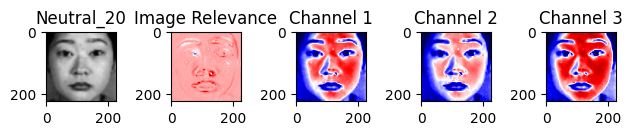

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  4
Contribution of pixels in the range [ 0.1 0.2 ] is :  4
Contribution of pixels in the range [ 0.2 0.3 ] is :  11
Contribution of pixels in the range [ 0.3 0.4 ] is :  21
Contribution of pixels in the range [ 0.4 0.5 ] is :  99
Contribution of pixels in the range [ 0.5 0.6 ] is :  12410
Contribution of pixels in the range [ 0.6 0.7 ] is :  137118
Contribution of pixels in the range [ 0.7 0.8 ] is :  758
Contribution of pixels in the range [ 0.8 0.9 ] is :  86
Contribution of pixels in the range [ 0.9 1.0 ] is :  16
Medium Neutral
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Neutral


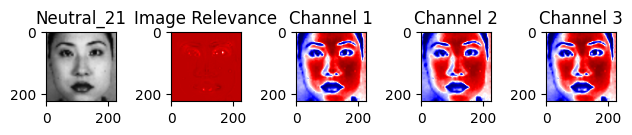

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  0
Contribution of pixels in the range [ 0.1 0.2 ] is :  1
Contribution of pixels in the range [ 0.2 0.3 ] is :  6
Contribution of pixels in the range [ 0.3 0.4 ] is :  2
Contribution of pixels in the range [ 0.4 0.5 ] is :  18
Contribution of pixels in the range [ 0.5 0.6 ] is :  36
Contribution of pixels in the range [ 0.6 0.7 ] is :  155
Contribution of pixels in the range [ 0.7 0.8 ] is :  4478
Contribution of pixels in the range [ 0.8 0.9 ] is :  145763
Contribution of pixels in the range [ 0.9 1.0 ] is :  68
High Neutral
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Fear


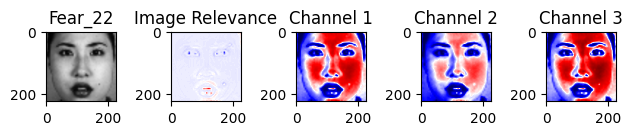

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  3
Contribution of pixels in the range [ 0.1 0.2 ] is :  8
Contribution of pixels in the range [ 0.2 0.3 ] is :  31
Contribution of pixels in the range [ 0.3 0.4 ] is :  182
Contribution of pixels in the range [ 0.4 0.5 ] is :  149795
Contribution of pixels in the range [ 0.5 0.6 ] is :  437
Contribution of pixels in the range [ 0.6 0.7 ] is :  50
Contribution of pixels in the range [ 0.7 0.8 ] is :  11
Contribution of pixels in the range [ 0.8 0.9 ] is :  8
Contribution of pixels in the range [ 0.9 1.0 ] is :  2
Medium Fear
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Fear


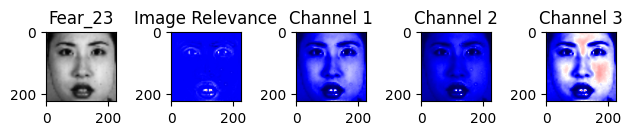

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  13
Contribution of pixels in the range [ 0.1 0.2 ] is :  1275
Contribution of pixels in the range [ 0.2 0.3 ] is :  147849
Contribution of pixels in the range [ 0.3 0.4 ] is :  1116
Contribution of pixels in the range [ 0.4 0.5 ] is :  162
Contribution of pixels in the range [ 0.5 0.6 ] is :  52
Contribution of pixels in the range [ 0.6 0.7 ] is :  33
Contribution of pixels in the range [ 0.7 0.8 ] is :  14
Contribution of pixels in the range [ 0.8 0.9 ] is :  9
Contribution of pixels in the range [ 0.9 1.0 ] is :  4
Low Fear
-------------------------------------------------------------------------------------------------------
Groundtruth for this image: Disgust


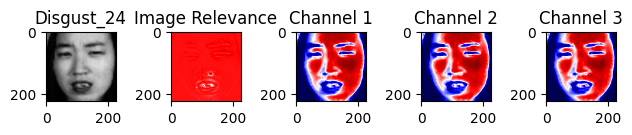

-------------------------------------------------------------------------------------------------------
Contribution of pixels in the range [ 0.0 0.1 ] is :  1
Contribution of pixels in the range [ 0.1 0.2 ] is :  2
Contribution of pixels in the range [ 0.2 0.3 ] is :  2
Contribution of pixels in the range [ 0.3 0.4 ] is :  15
Contribution of pixels in the range [ 0.4 0.5 ] is :  49
Contribution of pixels in the range [ 0.5 0.6 ] is :  287
Contribution of pixels in the range [ 0.6 0.7 ] is :  54502
Contribution of pixels in the range [ 0.7 0.8 ] is :  95621
Contribution of pixels in the range [ 0.8 0.9 ] is :  44
Contribution of pixels in the range [ 0.9 1.0 ] is :  4
Medium Disgust
-------------------------------------------------------------------------------------------------------


In [ ]:
# new code
# emotion_class = 'happy'  # Specify the emotion class for which you want to generate relevance scores

folder_path = '/content/drive/MyDrive/hm'
n = 1
image_names = []
positive = []
negative_counts = []
relevance_scores = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs).max(1).indices.detach().cpu().numpy()
    for i in range(inputs.shape[0]):
        image_id = i

        try:
            image_relevances = apply_lrp_on_vgg16(model, inputs[image_id])
            image_relevances = image_relevances.permute(0, 2, 3, 1).detach().cpu().numpy()[0]
            image_relevances = np.interp(image_relevances, (image_relevances.min(), image_relevances.max()), (0, 1))
            image_relevances_transposed = np.transpose(image_relevances, (2, 0, 1))
            pixel_relevance_scores = inputs[image_id].detach().cpu().numpy() * np.transpose(image_relevances, (2, 0, 1))

            pred_label = list(test_dataset.class_to_idx.keys())[list(test_dataset.class_to_idx.values()).index(labels[image_id])]
            image_name = pred_label + '_' + str(n)
            n += 1
            # Add condition to process images only for the specified emotion class
            # if pred_label == emotion_class:
            if outputs[image_id] == labels[image_id]:
                print("Groundtruth for this image:", pred_label)
                plt.clf()  # Clear the previous figure

                plt.subplot(1, 5, 1)
                plt.imshow(inputs[image_id].permute(1, 2, 0).detach().cpu().numpy())
                plt.title(image_name)

                plt.subplot(1, 5, 2)
                plt.imshow(image_relevances[:, :, 0], cmap="seismic")
                plt.title("Image Relevance")

                plt.subplot(1, 5, 3)
                plt.imshow(pixel_relevance_scores[0], cmap="seismic")
                plt.title("Channel 1")

                plt.subplot(1, 5, 4)
                plt.imshow(pixel_relevance_scores[1], cmap="seismic")
                plt.title("Channel 2")

                plt.subplot(1, 5, 5)
                plt.imshow(pixel_relevance_scores[2], cmap="seismic")
                plt.title("Channel 3")

                plt.tight_layout()
                plt.show()

                # p, z = contributed_pixels_count(1, pixel_relevance_scores)
                image_names.append(image_name)
                # positive_counts.append(p)
                # negative_counts.append(z)
                relevance_scores.append(image_relevances)
                print("-------------------------------------------------------------------------------------------------------")
                # print((image_relevances.shape))
                intensity = calculate_range_by_mean5(image_relevances)
                print(intensity+" "+pred_label)
                print("-------------------------------------------------------------------------------------------------------")

        except TypeError:
            continue


In [ ]:
print(1+2+2+15+49+287+54502+95621+44+4)
print(25+140434+9960+70+18+                             8+6+4+0+2)

150527
150527


In [ ]:
print(224*224*3)

150528


In [ ]:
print(image_relevances.shape)

(224, 224, 3)


In [ ]:
for i in pixel_relevance_scores[-1]:
  print(i)
print("the total count of pixel rel score", len(pixel_relevance_scores[-1]))

Streaming output truncated to the last 5000 lines.
 0.3979385  0.41434621 0.43073202 0.4444328  0.44993662 0.46094883
 0.46922299 0.47744281 0.48300077 0.48846026 0.49653841 0.4963245
 0.50165276 0.49376759 0.48848989 0.4830956  0.47771746 0.4778051
 0.48324089 0.48590843 0.49138165 0.49412567 0.49688846 0.49709175
 0.5000329  0.50253243 0.50240147 0.51072917 0.51658728 0.52478433
 0.53295005 0.54097285 0.54619775 0.55466538 0.56076141 0.57112494
 0.56915937 0.5634737  0.56112268 0.55466088 0.55073871 0.55407976
 0.55713011 0.56357291 0.56704061 0.56676825 0.56369052 0.56598883
 0.56280077 0.56352759 0.56097268 0.55737221 0.55398282 0.54981963
 0.54652303 0.5502741  0.55345664 0.55704655 0.56325878 0.56038963
 0.5546523  0.54777366 0.54172357 0.5326445  0.53209632 0.53848539
 0.54210207 0.54450724 0.54688493 0.55250439 0.55540158 0.56117835
 0.56692461 0.56964826 0.56963405 0.57180017 0.57145784 0.57158619
 0.57720376 0.58012475 0.58305694 0.58633401 0.58655266 0.5776822
 0.56915605 0.